In [2]:
from slope import CoverageComparisonStats, choose_best_transcript
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt

filename = 'Coots2017/ABCF1_r1_vs_control_r1.tsv'
basename = os.path.splitext(filename)[0]
slope_data = list(CoverageComparisonStats.each_in_file(filename))
slope_data = [info for info in slope_data  if info.geom_mean_coverage() >= 10]
slope_data = list(choose_best_transcript(slope_data))
print(len(slope_data))

transcript_lengths = [info.transcript_length for info in slope_data]
slopes = [info.slope for info in slope_data]
slopes_multipoint = [info.multipoint_slope for info in slope_data]
profile_difference = [info.profile_difference for info in slope_data]
polarities_control = [info.control_polarity_score for info in slope_data]
polarities_experiment = [info.experiment_polarity_score for info in slope_data]
polarity_deltas = [info.experiment_polarity_score - info.control_polarity_score for info in slope_data]
# plt.figure()
# sns.kdeplot(slopes)
# # plt.xlim(-0.02,0.02)
# plt.axvline(x=0, color='green')
# plt.savefig(f'{basename}_slope.png')

# plt.figure()
# sns.kdeplot(slopes_multipoint)
# # plt.xlim(-0.02,0.02)
# plt.axvline(x=0, color='green')
# plt.savefig(f'{basename}_slope_multipoint.png')

# plt.figure()
# sns.kdeplot(profile_difference)
# # plt.xlim(-0.02,0.02)
# plt.axvline(x=0, color='green')
# plt.savefig(f'{basename}_profile_diffs.png')

# plt.figure()
# sns.kdeplot(polarities_control, color='b')
# sns.kdeplot(polarities_experiment, color='r')
# # plt.xlim(-0.02,0.02)
# plt.axvline(x=0, color='green')
# plt.savefig(f'{basename}_polarities.png')

# plt.figure()
# sns.kdeplot(polarity_deltas)
# # plt.xlim(-0.02,0.02)
# plt.axvline(x=0, color='green')
# plt.savefig(f'{basename}_polarity_deltas.png')


4822


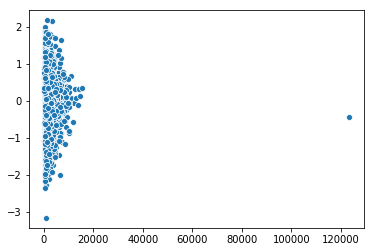

In [8]:
sns.scatterplot(transcript_lengths, slopes)

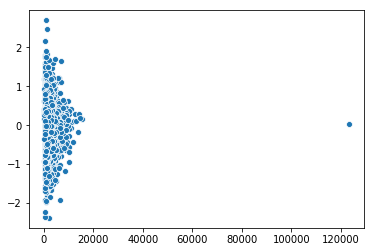

In [10]:
sns.scatterplot(transcript_lengths, slopes_multipoint)

In [4]:
import itertools
from collections import namedtuple

CoveredPosition = namedtuple('CoveredPosition', ['contig', 'pos', 'coverage'])

def parse_row(l):
    contig, pos, coverage = l.strip().split("\t")
    return CoveredPosition(contig, int(pos), int(coverage))

def parse_coverages_file(filename):
    with open(filename) as f:
        for row in f:
            yield parse_row(row)

def coverage_list(covered_positions, contig_length=None):
    coverages_by_pos = {covered_pos.pos: covered_pos.coverage  for covered_pos in covered_positions}
    if not contig_length:
        contig_length = max(coverages_by_pos.keys(), default=0)
    return [coverages_by_pos.get(pos, 0) for pos in range(1, contig_length + 1)]

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
from collections import defaultdict
from itertools import groupby
from gtf_parser import *

def get_transcript_id(rec):
    return rec.attributes['transcript_id']


In [7]:
genes = {}
transcripts_by_gene = defaultdict(list)
parts_by_transcript = defaultdict(list)
# for rec in parse_gtf('gencode.vM22.basic.annotation.gtf.gz'):
for rec in parse_gtf('annotation_large_sample.gtf'):
    if rec.attributes['gene_type'] != 'protein_coding':
        continue

    if rec.type == 'gene':
        gene_id = rec.attributes['gene_id']
        genes[gene_id] = rec

    else:
        if rec.attributes['transcript_type'] != 'protein_coding':
            continue

        if rec.type == 'transcript':
            gene_id = rec.attributes['gene_id']
            transcripts_by_gene[gene_id].append(rec)
        else:
            transcript_id = rec.attributes['transcript_id']
            parts_by_transcript[transcript_id].append(rec)


In [8]:
for gene_id, gene in genes.items():
    for transcript in transcripts_by_gene[gene_id]:
        transcript_id = transcript.attributes['transcript_id']
        parts = parts_by_transcript[transcript_id]

        exons = [part   for part in parts   if part.type == 'exon']
        cds_segments = [part for part in parts if part.type == 'CDS']
        if len( { segment.strand for segment in (exons + cds_segments) } ) != 1:
            raise Exception('Different strands')
        strand = exons[0].strand

        if strand == '+':
            # genomic coordinates
            cds_start = min([rec.start for rec in cds_segments])
            len_exons_before_cds = sum(  (exon.end - exon.start + 1) for exon in exons  if exon.end < cds_start  )
            exons_with_cds = [exon for exon in exons  if exon.start <= cds_start <= exon.end]
            if len(exons_with_cds) > 1:
                raise Exception('Several exons contain CDS start simultaneously')
            if len(exons_with_cds) == 0:
                raise Exception('No exons contain CDS start')
            exon_with_cds = exons_with_cds[0]
            len_exon_with_cds = cds_start - exon_with_cds.start + 1 
            cds_start_transcript = len_exon_with_cds + len_exons_before_cds
            # print(transcript_id, cds_start_transcript, sep='\t')
            # ToDo: посчитать cds_stop_transcript
        # ToDo: посчитать start и stop для отрицательной нитки

        len_transcript = sum((exon.end - exon.start + 1) for exon in exons)
        len_cds_in_transcript = sum((cds.end - cds.start + 1) for cds in cds_segments)
        print(gene_id, transcript_id, len_transcript, len_cds_in_transcript, sep='\t')


ENSMUSG00000051951.5	ENSMUST00000070533.4	3634	1941
ENSMUSG00000025900.12	ENSMUST00000208660.1	4170	4113
ENSMUSG00000025900.12	ENSMUST00000194992.6	858	855
ENSMUSG00000025900.12	ENSMUST00000027032.5	6869	6285
ENSMUSG00000025902.13	ENSMUST00000027035.9	3127	1257
ENSMUSG00000025902.13	ENSMUST00000195555.1	1977	873
ENSMUSG00000025902.13	ENSMUST00000192650.5	3242	1062
ENSMUSG00000025902.13	ENSMUST00000116652.7	1512	1257
ENSMUSG00000033845.13	ENSMUST00000130201.7	1894	612
ENSMUSG00000033845.13	ENSMUST00000156816.6	4203	885
ENSMUSG00000033845.13	ENSMUST00000146665.2	1569	504
ENSMUSG00000025903.14	ENSMUST00000027036.10	2507	690
ENSMUSG00000025903.14	ENSMUST00000150971.7	877	663
ENSMUSG00000025903.14	ENSMUST00000119612.8	529	276
ENSMUSG00000025903.14	ENSMUST00000115529.7	930	588
ENSMUSG00000033813.15	ENSMUST00000081551.13	2547	903
ENSMUSG00000033813.15	ENSMUST00000165720.2	2854	936
ENSMUSG00000002459.17	ENSMUST00000002533.14	1778	717
ENSMUSG00000002459.17	ENSMUST00000118000.7	2125	1116
ENSMUSG

In [9]:
for gene_id, transcripts in transcripts_by_gene.items():
    print(gene_id, len(transcripts))

ENSMUSG00000051951.5 1
ENSMUSG00000025900.12 3
ENSMUSG00000025902.13 4
ENSMUSG00000033845.13 3
ENSMUSG00000025903.14 4
ENSMUSG00000033813.15 2
ENSMUSG00000002459.17 3
ENSMUSG00000033793.12 3
ENSMUSG00000025905.13 3
ENSMUSG00000033774.4 1
ENSMUSG00000025907.14 1
ENSMUSG00000087247.3 1
ENSMUSG00000033740.17 6
ENSMUSG00000051285.17 1
ENSMUSG00000025909.16 4
ENSMUSG00000061024.8 1
ENSMUSG00000025911.14 1
ENSMUSG00000067879.3 1
ENSMUSG00000025912.16 2
ENSMUSG00000045210.8 1
ENSMUSG00000025915.14 4
ENSMUSG00000046101.16 5
ENSMUSG00000099032.2 2
ENSMUSG00000025916.10 1
ENSMUSG00000025917.9 1
ENSMUSG00000056763.16 6
ENSMUSG00000067851.11 2
ENSMUSG00000042501.12 1
ENSMUSG00000048960.13 1
ENSMUSG00000057715.13 5
ENSMUSG00000016918.15 4
ENSMUSG00000025938.16 6
ENSMUSG00000042414.7 1
ENSMUSG00000005886.14 3
ENSMUSG00000025935.10 1
ENSMUSG00000025937.6 1
ENSMUSG00000067813.3 1
ENSMUSG00000025932.14 4
ENSMUSG00000025930.6 1
ENSMUSG00000032769.5 2
ENSMUSG00000092083.4 2
ENSMUSG00000025925.14 2
ENSMUS

In [10]:
transcripts_of_interest = {transcript.attributes['transcript_id'] for transcript in transcripts_by_gene['ENSMUSG00000025938.16']}
print(transcripts_of_interest)

{'ENSMUST00000188454.6', 'ENSMUST00000136197.7', 'ENSMUST00000115403.8', 'ENSMUST00000147606.2', 'ENSMUST00000146763.7', 'ENSMUST00000115402.7'}


In [ ]:
import itertools
filename = 'METTL3_coverage.tsv'
contigs_iterator = itertools.groupby(parse_coverages_file(filename), key=lambda coverage_pos: coverage_pos.contig)
# for contig, contig_coverages in itertools.islice(contigs_iterator, 5):
for contig, contig_coverages in contigs_iterator:
    if contig not in transcripts_of_interest:
        continue
    # print(len(list(contig_coverages)))
    contig_coverages = list(contig_coverages)
    read_number = len(contig_coverages)
    coverage = coverage_list(contig_coverages)
    print(contig, read_number, sep="\t")
#     print(coverage)
    plt.figure(figsize=(20,5))
    plt.xlim(0,10000)
    plt.plot(coverage)
#     break


In [ ]:
import numpy as np
import pandas
def bin_centers(bins):
    return (bins[:-1] + bins[1:]) / 2

polarities_mettl3 = pandas.read_csv('polarities_METTL3.tsv', sep='\t')
polarities_abcf1 = pandas.read_csv('polarities_ABCF1.tsv', sep='\t')
polarities_control = pandas.read_csv('polarities_control.tsv', sep='\t')

# polarities_mettl3 = polarities[ polarities_mettl3.mean_cds_coverage > 1 ]
# polarities_abcf1 = polarities[ polarities_abcf1.mean_cds_coverage > 1 ]
# polarities_control = polarities[ polarities_control.mean_cds_coverage > 1 ]
# polarities = polarities[(polarities['mean_cds_coverage'] >= 5) & (polarities['mean_cds_coverage'] <= 500)]
# polarities.head()
# plt.plot(sorted(polarities['polarity_score']))

hist_mettl3, bins_mettl3 = np.histogram(polarities_mettl3['stabilized_polarity_score'], bins=100, range=(-1,1))
hist_abcf1, bins_abcf1 = np.histogram(polarities_abcf1['stabilized_polarity_score'], bins=100, range=(-1,1))
hist_control, bins_control = np.histogram(polarities_control['stabilized_polarity_score'], bins=100, range=(-1,1))
# hist_2, bins_2 = np.histogram(polarities_mettl3['polarity_score'], bins=100, range=(-1,1))

# bin_centers = (bins[:-1] + bins[1:]) / 2
# bin_centers_2 = (bins_2[:-1] + bins_2[1:]) / 2
# plt.plot(sorted(polarities_mettl3.mean_cds_coverage))

plt.figure(figsize=(15,8))
plt.plot(bin_centers(bins_mettl3), hist_mettl3)
plt.plot(bin_centers(bins_abcf1), hist_abcf1)
plt.plot(bin_centers(bins_control), hist_control)
plt.legend(['METTL3', 'ABCF1', 'control'])
# plt.plot(bin_centers_2, hist_2)

# plt.figure()
# hist_slope, bins_slope = np.histogram(polarities_mettl3['slope'], bins=100)
# bins_slope_centers = (bins_slope[:-1] + bins_slope[1:]) / 2
# plt.plot(bins_slope_centers, hist_slope)

In [91]:
import sklearn.linear_model
model = sklearn.linear_model.LinearRegression()
xs = [[1], [2], [2.5], [3]]
ys = [1, 4, 4, 5]
model.fit(xs, ys, sample_weight=[1,2,1,1,])
slope = model.coef_[0]
slope

1.909090909090909

In [14]:
import numpy as np
import pandas
def bin_centers(bins):
    return (bins[:-1] + bins[1:]) / 2

In [ ]:
# sample = 'ABCF1'
# polarities_comparison = pandas.read_csv(f'polarities_control_{sample}_slopelog.tsv', sep='\t')

# polarities_comparison = polarities_comparison[ polarities_comparison.mean_cds_coverage_1 >= 1 ]
# polarities_comparison = polarities_comparison[ polarities_comparison.mean_cds_coverage_2 >= 1 ]

# polarity_deltas = polarities_comparison['polarity_score_2'] - polarities_comparison['polarity_score_1']
# # polarity_deltas = polarity_deltas[polarity_deltas != 0]
# # polarity_deltas = polarities_comparison.delta_angle
# hist, bins = np.histogram(polarity_deltas,bins=101)

# plt.figure(figsize=(15,8))
# plt.plot(bin_centers(bins), hist)
# plt.xlim(-1.5,1.5)
# plt.axvline(x=0, color='red')
# # plt.legend(['METTL3', 'ABCF1', 'control'])
# # plt.plot(bin_centers_2, hist_2)

# # plt.figure()
# # hist_slope, bins_slope = np.histogram(polarities_mettl3['slope'], bins=100)
# # bins_slope_centers = (bins_slope[:-1] + bins_slope[1:]) / 2
# # plt.plot(bins_slope_centers, hist_slope)
# plt.figure(figsize=(15,8))
# hist_1, bins_1 = np.histogram(polarities_comparison['polarity_score_1'], bins=101)
# hist_2, bins_2 = np.histogram(polarities_comparison['polarity_score_2'], bins=101)
# plt.plot(bin_centers(bins_1), hist_1)
# plt.plot(bin_centers(bins_2), hist_2)
# plt.xlim(-1,1)
# plt.legend(['control', sample])
# plt.axvline(x=0, color='red')

# plt.figure(figsize=(15,8))
# hist_slope, bins_slope = np.histogram(polarities_comparison['slope'], bins=1001, )
# plt.plot(bin_centers(bins_slope), hist_slope)
# plt.xlim(-0.02,0.02)
# plt.axvline(x=0, color='red')

# num_neg_slope = sum(1 for slope in polarities_comparison.slope if slope < 0)
# num_pos_slope = sum(1 for slope in polarities_comparison.slope if slope > 0)
# print(f'Negative slope: {num_neg_slope}; Positive slope: {num_pos_slope}')

Negative polarity difference: 1002; Positive polarity difference: 505; Ratio: 0.5039920159680639
Negative slope: 870; Positive slope: 637; Ratio: 0.732183908045977
poldiff Q1: -0.08996924338413971; Q2: -0.031110096852652536; Q3: 0.021049135479355177; Q1/Q2: 2.891962818703622; Q3/Q2: -0.6766014126876776
slope Q1: -0.0006956179546280896; Q2: -0.000101361095827653; Q3: 0.000389164591723594; Q1/Q2: 6.862770661150582; Q3/Q2: -3.8393881651131814


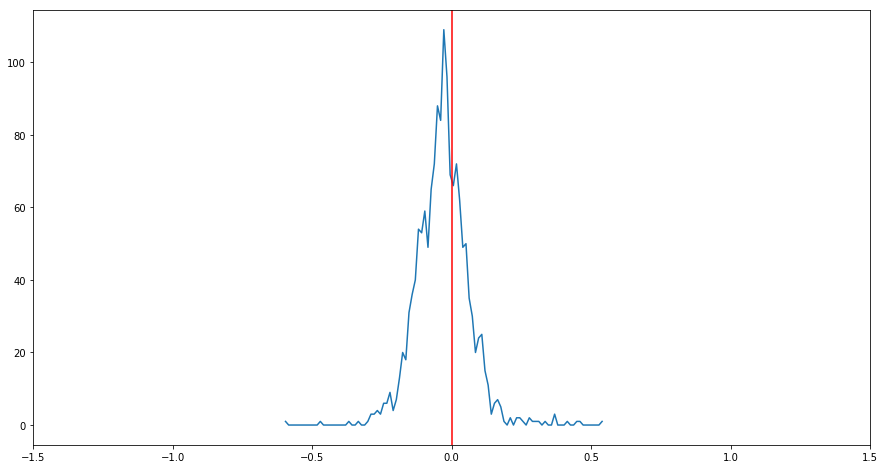

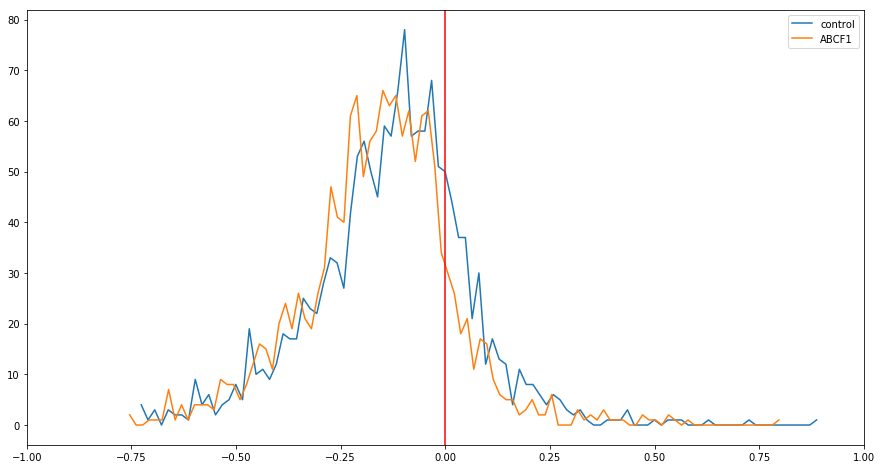

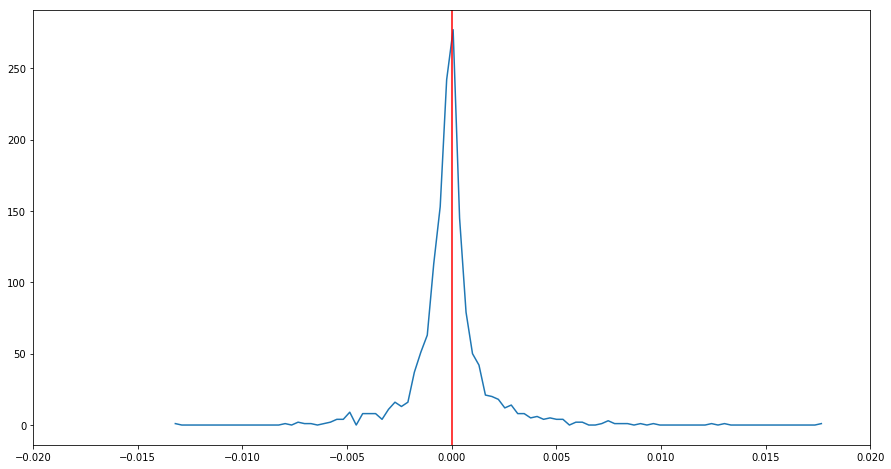

In [48]:
sample = 'ABCF1'
# polarities_comparison = pandas.read_csv(f'polarities_control_{sample}_slopelog.tsv', sep='\t')
polarities_comparison = pandas.read_csv(f'polarities_control_{sample}_slope_wo_weights.tsv', sep='\t')

polarities_comparison = polarities_comparison[ polarities_comparison.mean_cds_coverage_1 >= 50 ]
polarities_comparison = polarities_comparison[ polarities_comparison.mean_cds_coverage_2 >= 50 ]

polarity_deltas = polarities_comparison['polarity_score_2'] - polarities_comparison['polarity_score_1']
# polarity_deltas = polarity_deltas[polarity_deltas != 0]
# polarity_deltas = polarities_comparison.delta_angle
hist, bins = np.histogram(polarity_deltas,bins=101)

plt.figure(figsize=(15,8))
plt.plot(bin_centers(bins), hist)
plt.axvline(x=0, color='red')
plt.xlim(-1.5,1.5)
# plt.legend(['METTL3', 'ABCF1', 'control'])
# plt.plot(bin_centers_2, hist_2)

# plt.figure()
# hist_slope, bins_slope = np.histogram(polarities_mettl3['slope'], bins=100)
# bins_slope_centers = (bins_slope[:-1] + bins_slope[1:]) / 2
# plt.plot(bins_slope_centers, hist_slope)
plt.figure(figsize=(15,8))
hist_1, bins_1 = np.histogram(polarities_comparison['polarity_score_1'], bins=101)
hist_2, bins_2 = np.histogram(polarities_comparison['polarity_score_2'], bins=101)
plt.plot(bin_centers(bins_1), hist_1)
plt.plot(bin_centers(bins_2), hist_2)
plt.legend(['control', sample])
plt.xlim(-1,1)
plt.axvline(x=0, color='red')

plt.figure(figsize=(15,8))
hist_slope, bins_slope = np.histogram(polarities_comparison['slope'], bins=101, )
plt.plot(bin_centers(bins_slope), hist_slope)
plt.xlim(-0.02,0.02)
plt.axvline(x=0, color='red')

num_neg_polaritydiff = sum(1 for poldiff in polarity_deltas if poldiff < 0)
num_pos_polaritydiff = sum(1 for poldiff in polarity_deltas if poldiff > 0)
print(f'Negative polarity difference: {num_neg_polaritydiff}; Positive polarity difference: {num_pos_polaritydiff}; Ratio: {num_pos_polaritydiff / num_neg_polaritydiff}')

num_neg_slope = sum(1 for slope in polarities_comparison.slope if slope < 0)
num_pos_slope = sum(1 for slope in polarities_comparison.slope if slope > 0)
print(f'Negative slope: {num_neg_slope}; Positive slope: {num_pos_slope}; Ratio: {num_pos_slope / num_neg_slope}')

sorted_pol_deltas = list(sorted(polarity_deltas))
q1 = sorted_pol_deltas[len(sorted_pol_deltas) // 4]
q2 = sorted_pol_deltas[len(sorted_pol_deltas) // 2]
q3 = sorted_pol_deltas[len(sorted_pol_deltas) * 3 // 4]
print(f'poldiff Q1: {q1}; Q2: {q2}; Q3: {q3}; Q1/Q2: {q1/q2}; Q3/Q2: {q3/q2}')

sorted_slopes = list(sorted(polarities_comparison['slope']))
q1 = sorted_slopes[len(sorted_slopes) // 4]
q2 = sorted_slopes[len(sorted_slopes) // 2]
q3 = sorted_slopes[len(sorted_slopes) * 3 // 4]
print(f'slope Q1: {q1}; Q2: {q2}; Q3: {q3}; Q1/Q2: {q1/q2}; Q3/Q2: {q3/q2}')